In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# 보스턴 주택 데이터셋 URL
data_url = "http://lib.stat.cmu.edu/datasets/boston"

# 데이터 읽기
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# 데이터를 2줄씩 병합하여 13개 컬럼으로 변환
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
raw_df

# # DataFrame으로 변환
columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
bostonDF = pd.DataFrame(data, columns=columns)

# # PRICE 컬럼 추가 
bostonDF['PRICE'] = target

print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.columns

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jeongbs1\AppData\Local\Temp\ipykernel_6232\654510500.py:14: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


Boston 데이타셋 크기 : (506, 14)


In [13]:
from scipy.stats import normaltest

# Test the normality of each feature
p_values = []
for col in X_data.columns:
    stat, p_value = normaltest(X_data[col])  # D'Agostino's K-squared test
    p_values.append(p_value)

# Store the results in a DataFrame for better visualization
normality_results = pd.DataFrame({
    'Feature': X_data.columns,
    'p-value': p_values})

# Define a significance level (e.g., alpha = 0.05)
alpha = 0.05

# Determine if each feature is normally distributed (True if p > alpha)
normality_results['Normality'] = normality_results['p-value'] > alpha

normality_results


,Feature,p-value,Normality
0,CRIM,6.320632e-123,False
1,ZN,2.702371e-50,False
2,INDUS,5.989300e-92,False
3,CHAS,1.815921e-80,False
4,NOX,7.159367e-09,False
5,RM,5.902608e-09,False
6,AGE,1.619177e-25,False
7,DIS,2.904509e-15,False
8,RAD,4.034963e-26,False
9,TAX,1.034519e-55,False


In [29]:
def freedman_diaconis_bin_width(data_column):
    q25, q75 = np.percentile(data_column, [25, 75])  # IQR 계산
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data_column) ** (1 / 3))  # bin 너비 계산
    data_range = data_column.max() - data_column.min()  # 데이터 범위 계산
    bins = int(data_range / bin_width)  # bin 개수 계산
    return bins


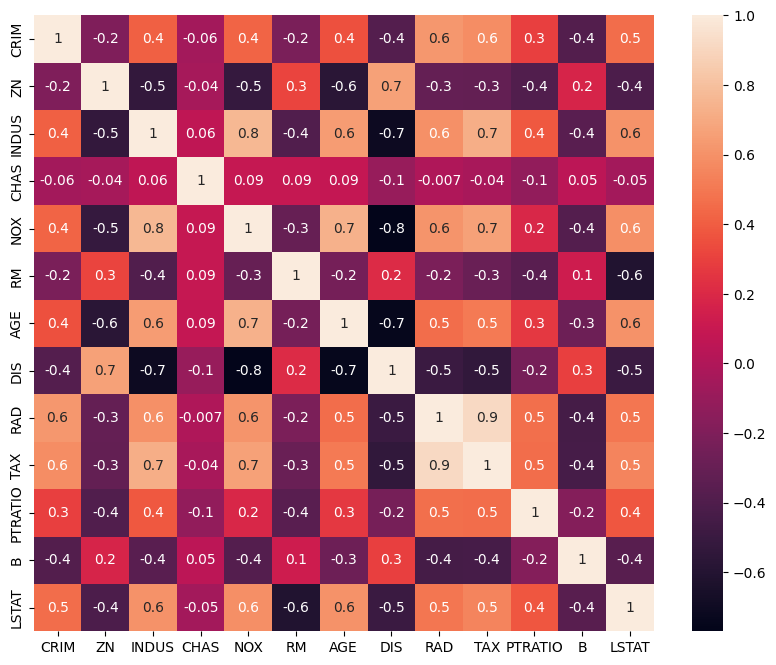

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_data.corr(method="pearson")
plt.figure(figsize=(10,8))

sns.heatmap(corr, annot=True, fmt='.1g')
plt.show()

In [44]:
corr[(abs(corr)>0.7)&(abs(corr)<0.99)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INDUS,NaN,NaN,NaN,NaN,0.763651,NaN,NaN,-0.708027,NaN,0.720760,NaN,NaN,NaN
CHAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOX,NaN,NaN,0.763651,NaN,NaN,NaN,0.731470,-0.769230,NaN,NaN,NaN,NaN,NaN
RM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,NaN,NaN,NaN,NaN,0.731470,NaN,NaN,-0.747881,NaN,NaN,NaN,NaN,NaN
DIS,NaN,NaN,-0.708027,NaN,-0.769230,NaN,-0.747881,NaN,NaN,NaN,NaN,NaN,NaN
RAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.910228,NaN,NaN,NaN
TAX,NaN,NaN,0.720760,NaN,NaN,NaN,NaN,NaN,0.910228,NaN,NaN,NaN,NaN


In [43]:
corr[(abs(corr)>0.7)&(abs(corr)<0.99)].stack().index.get_level_values(0).unique()

Index(['INDUS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX'], dtype='object')

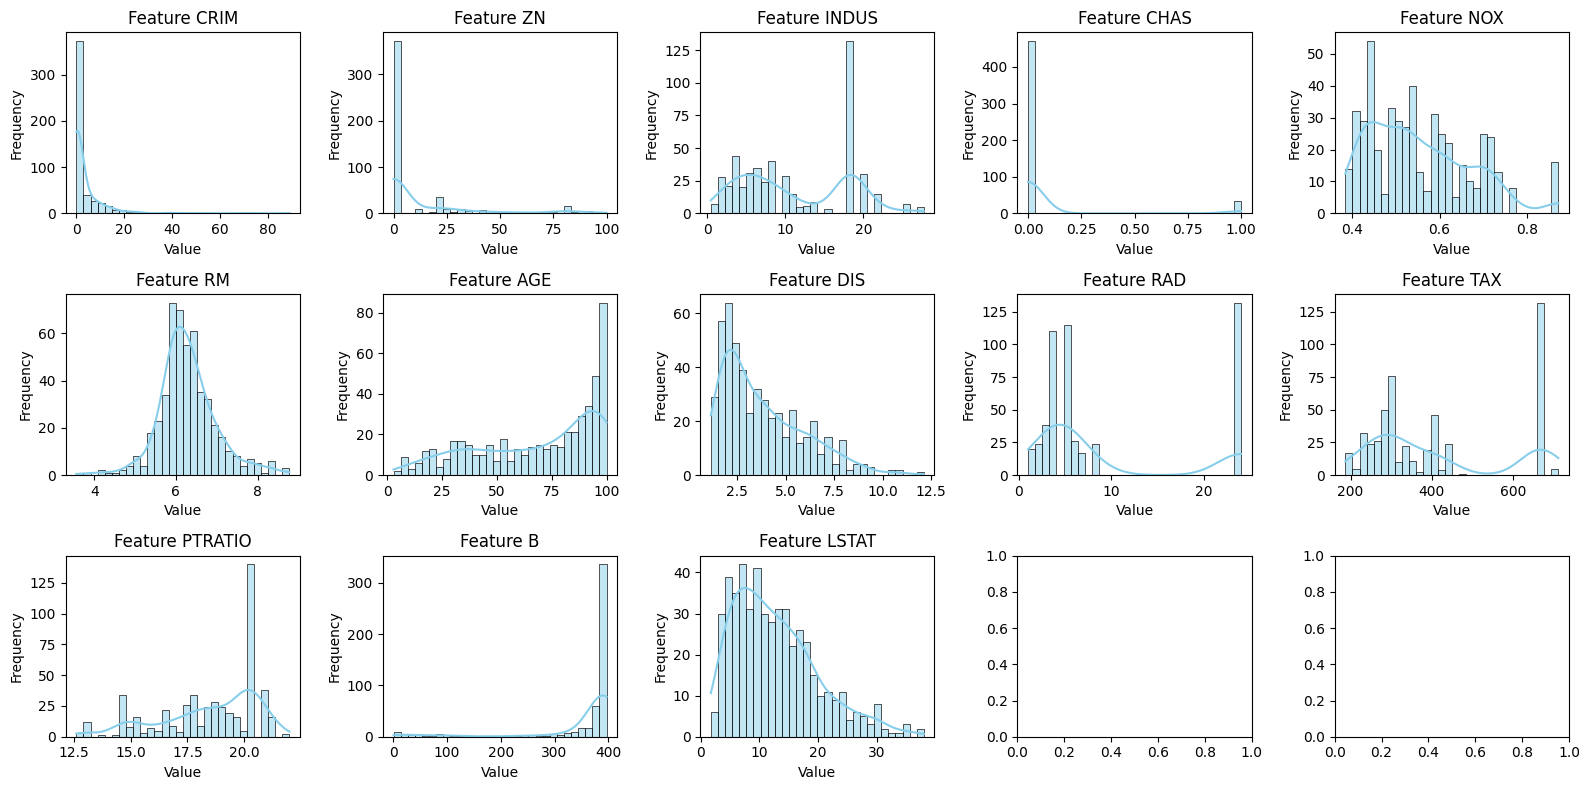

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(16,8) , ncols=5 , nrows=3)
lm_features = X_data.columns
for i , feature in enumerate(lm_features):
    # print(i, feature)
    row = int(i/5)
    col = i%5
    # bins = int(freedman_diaconis_bin_width(X_data[feature]))
    sns.histplot(X_data[feature], kde=True, color='skyblue', bins=30, ax=axs[row][col])
    axs[row][col].set_title(f'Feature {feature}')
    axs[row][col].set_xlabel('Value')
    axs[row][col].set_ylabel('Frequency')
plt.tight_layout()

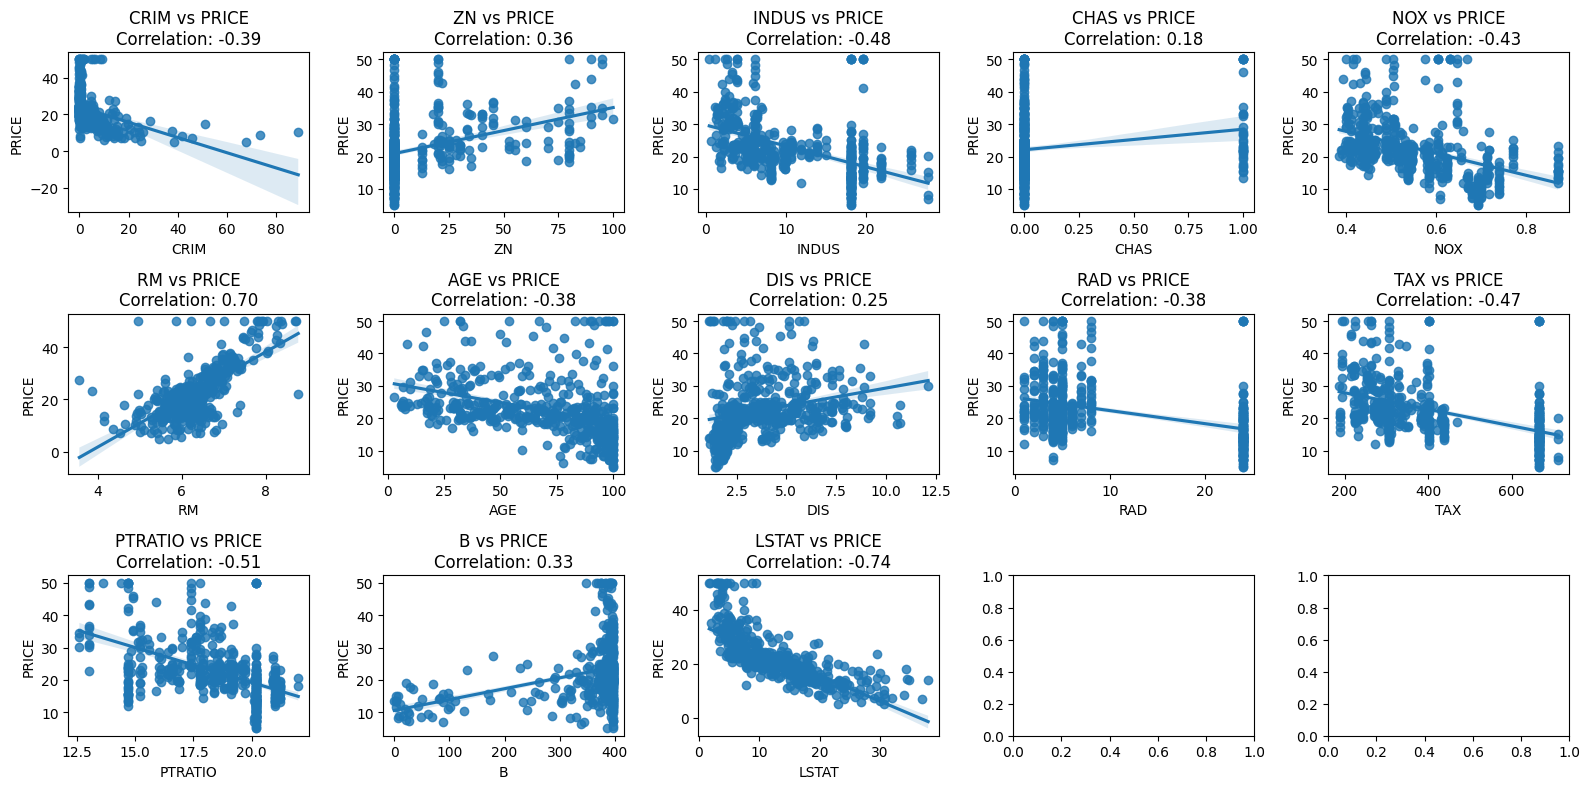

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=5 , nrows=3)
# lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
lm_features = X_data.columns
for i , feature in enumerate(lm_features):
    # print(i, feature)
    row = int(i/5)
    col = i%5
    # print(i, feature, row, col)
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    corr, _ = pearsonr(bostonDF[feature], bostonDF['PRICE'])
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])
    axs[row][col].set_title(f'{feature} vs PRICE\nCorrelation: {corr:.2f}')

plt.tight_layout()

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  #사이킷런 1.2 부터는 보스턴 주택가격 데이터가 없어진다는 warning 메시지 출력 제거

X_features = X_data
y_label = y_target

X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.3, random_state=156 )

# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))



MSE : 17.297 , RMSE : 4.159
Variance score : 0.757
절편 값: 40.995595172164506
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [52]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [41]:
from sklearn.metrics import accuracy_score
rfl = RandomForestRegressor(n_estimators=1000)
rfl.fit(X_train , y_train)
pred = rfl.predict(X_test)
# accuracy = accuracy_score(y_test , pred)
# print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  #사이킷런 1.2 부터는 보스턴 주택가격 데이터가 없어진다는 warning 메시지 출력 제거

X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_features, y_label, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))


 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


<Axes: xlabel='None', ylabel='None'>

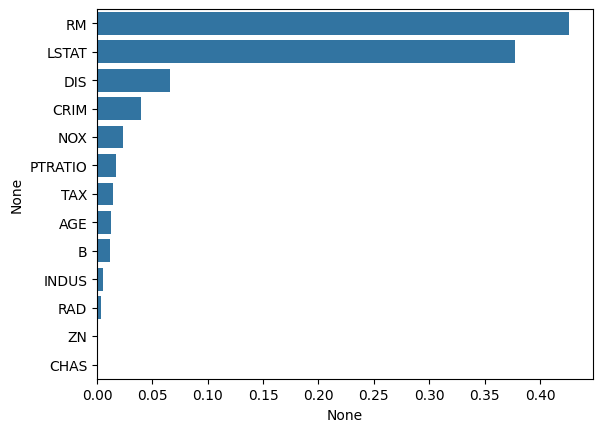

In [4]:
import seaborn as sns
# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
rf.fit(X_data, y_target)

feature_series = pd.Series(data=rf.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [63]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 
rfl_search_space = {'max_depth': hp.quniform('max_depth', 5, 50, 1),
                    'min_samples_leaf' : hp.quniform('min_samples_leaf', 1, 20, 1),
                    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1)
               }
rfl_search_space

{'max_depth': <hyperopt.pyll.base.Apply at 0x1a77e8bab10>,
 'min_samples_leaf': <hyperopt.pyll.base.Apply at 0x1a7027d6a50>,
 'min_samples_split': <hyperopt.pyll.base.Apply at 0x1a7027d5460>}

In [64]:
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK
from sklearn.metrics import r2_score

# fmin()에서 입력된 search_space값으로 입력된 모든 값은 실수형임. 
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함. 
# 정확도는 높은 수록 더 좋은 수치임. -1* 정확도를 곱해서 큰 정확도 값일 수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 n_estimators는 100으로 축소
    rfl = RandomForestRegressor(n_estimators=1000, 
                                max_depth=int(round(search_space['max_depth'])),
                                min_samples_split=int(round(search_space['min_samples_split'])),
                                min_samples_leaf=int(round(search_space['min_samples_leaf'])),
                                n_jobs=-1)

    neg_mse_scores = cross_val_score(rfl, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    # r2 = cross_val_score(rfl, X_data, y_target, scoring="r2", cv = 5)
    
        
    # accuracy는 cv=3 개수만큼의 정확도 결과를 가지므로 이를 평균해서 반환하되 -1을 곱해줌. 
    return {'loss': neg_mse_scores, 'status': STATUS_OK}

In [65]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=rfl_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [05:54<00:00,  7.09s/trial, best loss: 4.4275275554954145]
best: {'max_depth': 13.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0}


In [75]:
from sklearn.metrics import mean_squared_error , r2_score

def get_reg_eval(y_test, pred=None):
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    print(rmse, r2)

In [76]:
rf_bo = RandomForestRegressor(n_estimators=1000, 
                                max_depth=int(round(best['max_depth'])),
                                min_samples_split=int(round(best['min_samples_split'])),
                                min_samples_leaf=int(round(best['min_samples_leaf'])),
                                n_jobs=-1)
pred = rf_bo.fit(X_train, y_train).predict(X_test)

In [77]:
get_reg_eval(y_test, pred)

2.7099564423434317 0.9131425541314998


In [78]:
ftr_importances_values = rf_bo.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_importances.sort_values(ascending=False)

LSTAT      0.400921
RM         0.391901
DIS        0.071069
CRIM       0.039164
NOX        0.022305
AGE        0.017186
PTRATIO    0.017121
TAX        0.015827
B          0.011981
INDUS      0.007041
RAD        0.003285
ZN         0.001144
CHAS       0.001057
dtype: float64

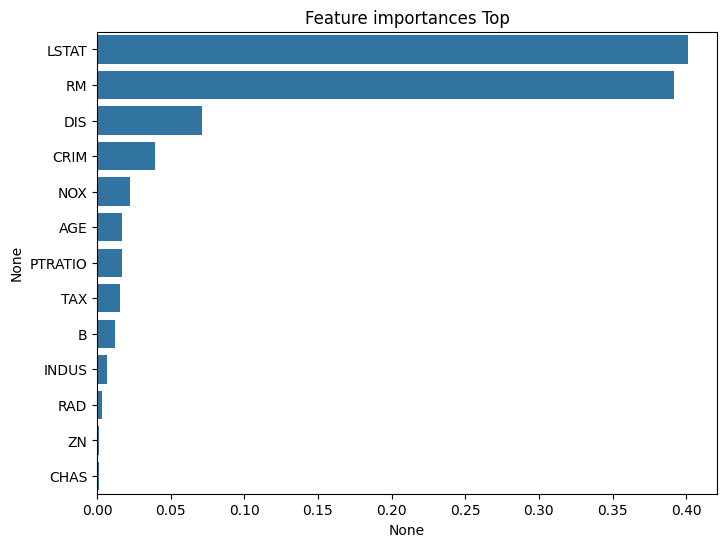

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_bo.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature importances Top')
sns.barplot(x=ftr_top , y = ftr_top.index)
plt.show()